# 大类资产收益率与波动率预测模型

本项目使用LSTM模型预测大类资产的收益率和波动率，并与基于历史值的预测结果进行对比。

## 1. 环境准备

导入必要的库并设置环境：
- 数据处理：pandas, numpy
- 机器学习：sklearn, keras
- 可视化：matplotlib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.optimizers import Adam

import random
import tensorflow as tf

In [2]:
# 设置中文字体显示
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
matplotlib.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)  # 在所有初始化前调用

## 2. 数据预处理

### 2.1 数据加载与合并
- 加载指数行情数据
- 加载美国国债指数数据
- 加载利率和汇率数据
- 合并数据集并处理缺失值

### 2.2 数据清洗
- 向前填充缺失值
- 数据类型转换与尺度调整
- 导出处理后的数据

In [4]:
# 加载并预处理指数行情序列数据集
raw_data = pd.read_csv('Data/指数行情V2_1.csv')
raw_data['日期'] = pd.to_datetime(raw_data['日期'], format='%Y/%m/%d')
for column in raw_data.columns:
    if (raw_data[column].dtype == 'object'):
        raw_data[column] = raw_data[column].astype('float64')

# 加载并处理美国国债行情指数序列数据集
raw_data_1 = pd.read_csv('Data/美国国债指数.csv')
raw_data_1['日期'] = pd.to_datetime(raw_data_1['日期'], format='%Y-%m-%d')

# 合并数据集
raw_data = pd.merge(raw_data, raw_data_1, on='日期', how='left')

In [5]:
raw_data.isnull().sum()

日期                 0
上证指数             171
沪深300            171
中证1000           171
中证2000           171
纳斯达克100          109
标普500            109
道琼斯工业平均          109
中债国债总指数          119
中债信用债总指数         119
中债企业债指数          119
中债地方政府债指数        119
中债国债及政策性银行债指数    119
恒生指数             148
恒生科技指数           148
南华黑色             171
南华黄金             171
美国国债指数            83
dtype: int64

In [6]:
raw_data.ffill(inplace=True)  # 符合金融实务中“无交易则无收益”的默认逻辑

In [7]:
raw_data

,日期,上证指数,沪深300,中证1000,中证2000,纳斯达克100,标普500,道琼斯工业平均,中债国债总指数,中债信用债总指数,中债企业债指数,中债地方政府债指数,中债国债及政策性银行债指数,恒生指数,恒生科技指数,南华黑色,南华黄金,美国国债指数
0,2018-06-29,2847.42,3510.98,5608.54,1822.81,7040.80,2718.37,24271.41,175.91,167.38,169.91,131.70,149.88,28955.11,5002.23,1000.00,1111.82,563.99
1,2018-07-02,2775.56,3407.96,5538.09,1802.50,7097.82,2726.71,24307.18,176.04,167.60,170.12,131.80,150.06,28955.11,5002.23,974.73,1114.68,563.24
2,2018-07-03,2786.89,3409.28,5601.59,1834.27,7014.55,2713.22,24174.82,176.06,167.74,170.25,131.86,150.12,28545.57,4932.99,975.96,1113.86,565.13
3,2018-07-04,2759.13,3363.75,5500.67,1794.89,7014.55,2713.22,24174.82,176.02,167.82,170.29,131.86,150.15,28241.67,4770.80,978.36,1116.94,565.17
4,2018-07-05,2733.88,3342.44,5352.66,1740.87,7101.05,2736.61,24356.74,176.15,167.97,170.45,131.92,150.32,28182.09,4719.52,971.62,1117.35,565.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1827,2025-05-01,3279.03,3770.57,5950.12,2442.89,19786.71,5604.14,40752.96,247.38,222.24,246.17,189.50,206.44,22119.41,5087.42,2417.16,2862.31,617.33
1828,2025-05-02,3279.03,3770.57,5950.12,2442.89,20102.61,5686.67,41317.43,247.38,222.24,246.17,189.50,206.44,22504.68,5244.06,2417.16,2862.31,613.16
1829,2025-05-05,3279.03,3770.57,5950.12,2442.89,19967.94,5650.38,41218.83,247.38,222.24,246.17,189.50,206.44,22504.68,5244.06,2417.16,2862.31,611.76
1830,2025-05-06,3316.11,3808.54,6102.92,2522.31,19791.35,5606.91,40829.00,247.49,222.34,246.28,189.68,206.51,22662.71,5239.50,2397.08,2915.50,613.50


In [8]:
raw_data.to_csv('Data/指数行情_processed_V2_1.csv', index=False, encoding='utf-8-sig')

## 3. 特征工程

### 3.1 计算金融指标
- 对数收益率计算（基于全部资产价格序列）
- 滚动波动率计算（20日窗口）

### 3.2 数据准备
- 构建时间序列特征（20天回溯窗口）
- 准备目标变量
  - 未来20日累计收益率 (17个资产)
  - 未来20日波动率 (17个资产)
- 准备历史法对照组
  - 过去20日累计收益率
  - 训练集历史均值收益率
  - 过去60日波动率（调整尺度）

In [9]:
# 计算对数收益率
log_returns = pd.DataFrame()
for column in raw_data.columns[1:]:
    log_returns[f'{column}_收益率'] = np.log(raw_data[column] / raw_data[column].shift(1))
log_returns['日期'] = raw_data['日期']
log_returns.set_index('日期', inplace=True)

In [10]:
log_returns.head()

,上证指数_收益率,沪深300_收益率,中证1000_收益率,中证2000_收益率,纳斯达克100_收益率,标普500_收益率,道琼斯工业平均_收益率,中债国债总指数_收益率,中债信用债总指数_收益率,中债企业债指数_收益率,中债地方政府债指数_收益率,中债国债及政策性银行债指数_收益率,恒生指数_收益率,恒生科技指数_收益率,南华黑色_收益率,南华黄金_收益率,美国国债指数_收益率
日期,,,,,,,,,,,,,,,,,
2018-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-02,-0.025561,-0.029781,-0.012641,-0.011205,0.008066,0.003063,0.001473,0.000739,0.001314,0.001235,0.000759,0.001200,0.000000,0.000000,-0.025595,0.002569,-0.001331
2018-07-03,0.004074,0.000387,0.011401,0.017472,-0.011801,-0.004960,-0.005460,0.000114,0.000835,0.000764,0.000455,0.000400,-0.014245,-0.013939,0.001261,-0.000736,0.003350
2018-07-04,-0.010011,-0.013445,-0.018181,-0.021703,0.000000,0.000000,0.000000,-0.000227,0.000477,0.000235,0.000000,0.000200,-0.010703,-0.033431,0.002456,0.002761,0.000071
2018-07-05,-0.009194,-0.006355,-0.027276,-0.030559,0.012256,0.008584,0.007497,0.000738,0.000893,0.000939,0.000455,0.001132,-0.002112,-0.010807,-0.006913,0.000367,-0.000071


In [11]:
# 计算滚动波动率
rolling_volatility = pd.DataFrame()
for column in log_returns.columns:
    rolling_volatility[f'{column}_波动率'] = log_returns[column].rolling(window=20).std()

In [12]:
# 合并对数收益率和滚动波动率
r_and_v = pd.merge(log_returns, rolling_volatility, left_index=True, right_index=True)
r_and_v.dropna(inplace=True)

In [13]:
r_and_v.head(10)

,上证指数_收益率,沪深300_收益率,中证1000_收益率,中证2000_收益率,纳斯达克100_收益率,标普500_收益率,道琼斯工业平均_收益率,中债国债总指数_收益率,中债信用债总指数_收益率,中债企业债指数_收益率,...,中债国债总指数_收益率_波动率,中债信用债总指数_收益率_波动率,中债企业债指数_收益率_波动率,中债地方政府债指数_收益率_波动率,中债国债及政策性银行债指数_收益率_波动率,恒生指数_收益率_波动率,恒生科技指数_收益率_波动率,南华黑色_收益率_波动率,南华黄金_收益率_波动率,美国国债指数_收益率_波动率
日期,,,,,,,,,,,,,,,,,,,,,
2018-07-27,-0.003002,-0.004256,-0.005835,-0.006510,-0.014148,-0.006584,-0.002982,0.001360,0.000591,0.000524,...,0.000874,0.000406,0.000456,0.000486,0.000926,0.008169,0.016393,0.010746,0.003243,0.002254
2018-07-30,-0.001581,-0.001748,-0.014525,-0.016939,-0.014311,-0.005771,-0.005683,0.000793,0.000945,0.001105,...,0.000875,0.000378,0.000448,0.000482,0.000920,0.008184,0.016711,0.008457,0.003188,0.002249
2018-07-31,0.002559,0.000734,-0.001172,0.000582,0.005391,0.004873,0.004273,0.001810,0.001062,0.001045,...,0.000948,0.000390,0.000458,0.000513,0.000993,0.007608,0.017463,0.008436,0.003186,0.002108
2018-08-01,-0.018198,-0.020179,-0.015698,-0.015019,0.005641,-0.001041,-0.003207,0.001016,0.000943,0.001218,...,0.000955,0.000399,0.000470,0.000507,0.000998,0.007459,0.015882,0.008820,0.003119,0.002190
2018-08-02,-0.020210,-0.022420,-0.024191,-0.027425,0.013556,0.004914,-0.000302,0.000226,0.001060,0.001159,...,0.000950,0.000407,0.000479,0.000507,0.000984,0.008999,0.016566,0.008464,0.003159,0.002238
2018-08-03,-0.010014,-0.016655,-0.013263,-0.012134,0.003161,0.004633,0.005372,0.000959,0.000647,0.000695,...,0.000916,0.000404,0.000477,0.000523,0.000993,0.008903,0.016802,0.009119,0.003136,0.002357
2018-08-06,-0.012957,-0.012753,-0.021344,-0.019245,0.005865,0.003532,0.001554,0.000564,0.001175,0.001561,...,0.000895,0.000422,0.000516,0.000540,0.000970,0.008399,0.015178,0.009961,0.003141,0.002321
2018-08-07,0.027063,0.028788,0.025903,0.026540,0.003175,0.002820,0.004957,-0.000113,0.000998,0.001386,...,0.000893,0.000405,0.000520,0.000535,0.000936,0.009207,0.016337,0.009854,0.003030,0.002387
2018-08-08,-0.012782,-0.016268,-0.016779,-0.015699,0.000924,-0.000262,-0.001764,-0.001692,0.000117,0.000288,...,0.001010,0.000401,0.000514,0.000681,0.001030,0.008790,0.016288,0.010119,0.002942,0.002316


In [14]:
r_and_v.describe()

,上证指数_收益率,沪深300_收益率,中证1000_收益率,中证2000_收益率,纳斯达克100_收益率,标普500_收益率,道琼斯工业平均_收益率,中债国债总指数_收益率,中债信用债总指数_收益率,中债企业债指数_收益率,...,中债国债总指数_收益率_波动率,中债信用债总指数_收益率_波动率,中债企业债指数_收益率_波动率,中债地方政府债指数_收益率_波动率,中债国债及政策性银行债指数_收益率_波动率,恒生指数_收益率_波动率,恒生科技指数_收益率_波动率,南华黑色_收益率_波动率,南华黄金_收益率_波动率,美国国债指数_收益率_波动率
count,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,...,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000
mean,0.000082,0.000044,0.000042,0.000176,0.000545,0.000378,0.000263,0.000187,0.000151,0.000199,...,0.001040,0.000274,0.000339,0.000640,0.000881,0.013609,0.022009,0.014479,0.007321,0.004524
std,0.010647,0.011952,0.015244,0.016346,0.015506,0.012555,0.012150,0.001176,0.000337,0.000425,...,0.000504,0.000156,0.000194,0.000432,0.000421,0.005546,0.008926,0.005686,0.003306,0.001840
min,-0.080391,-0.082087,-0.120974,-0.137325,-0.130032,-0.127652,-0.138418,-0.008136,-0.002292,-0.003106,...,0.000183,0.000080,0.000111,0.000126,0.000190,0.005207,0.007450,0.005977,0.002377,0.000000
25%,-0.004583,-0.005530,-0.006861,-0.006666,-0.005897,-0.004158,-0.004173,-0.000288,0.000000,0.000000,...,0.000682,0.000167,0.000213,0.000366,0.000579,0.010310,0.016401,0.010565,0.005208,0.003261
50%,0.000000,0.000000,0.000000,0.000000,0.000691,0.000165,0.000138,0.000158,0.000158,0.000217,...,0.000919,0.000221,0.000279,0.000499,0.000759,0.012418,0.019774,0.012487,0.006523,0.004273
75%,0.005047,0.005727,0.007544,0.008597,0.008367,0.006281,0.005573,0.000743,0.000307,0.000409,...,0.001246,0.000335,0.000396,0.000728,0.001061,0.014858,0.024786,0.017174,0.008882,0.005496
max,0.077551,0.081420,0.105654,0.105126,0.113528,0.090895,0.107643,0.010514,0.003478,0.005116,...,0.002947,0.000918,0.001122,0.002430,0.002286,0.035261,0.065935,0.035877,0.022760,0.014522


In [15]:
mean_returns = r_and_v.iloc[:1417, :17].mean().values
mean_returns

array([ 4.51903042e-05,  1.40288395e-05,  6.47393182e-05,  2.07744845e-04,
        5.36002360e-04,  3.25910342e-04,  2.22552879e-04,  1.62541824e-04,
        1.52830814e-04,  2.02970588e-04,  1.68432477e-04,  1.60113677e-04,
       -3.28136392e-04, -1.14736643e-04,  8.26491138e-04,  3.27499066e-04,
        9.49371891e-06])

In [16]:
r_and_v.shape

(1812, 34)

其他输入特征

In [17]:
raw_data_2 = pd.read_excel('Data/利率和汇率数据_V1.xlsx')

raw_data_2.replace(0, np.nan, inplace=True)

raw_data_2['日期'] = pd.to_datetime(raw_data_2['日期'], format='%Y%m%d')

raw_data_2.iloc[:, 1:3] = raw_data_2.iloc[:, 1:3].apply(lambda x: x / 100)

raw_data_2['CNYUSD'] = 0.1 / raw_data_2['CNYUSD']  # scaling

In [18]:
raw_data_2

,日期,R001,R007,CNYUSD
0,1971-06-01,NaN,NaN,NaN
1,1971-06-02,NaN,NaN,NaN
2,1971-06-03,NaN,NaN,NaN
3,1971-06-04,NaN,NaN,NaN
4,1971-06-07,NaN,NaN,NaN
...,...,...,...,...
14080,2025-05-12,0.014565,0.015499,0.013876
14081,2025-05-13,0.014343,0.015337,0.013891
14082,2025-05-14,0.014412,0.015440,0.013897
14083,2025-05-15,0.014477,0.015456,0.013896


In [19]:
X = pd.merge(r_and_v, raw_data_2, on='日期', how='left')  # 只添加利率汇率数据
X.ffill(inplace=True)

In [20]:
X.head(10)

,日期,上证指数_收益率,沪深300_收益率,中证1000_收益率,中证2000_收益率,纳斯达克100_收益率,标普500_收益率,道琼斯工业平均_收益率,中债国债总指数_收益率,中债信用债总指数_收益率,...,中债地方政府债指数_收益率_波动率,中债国债及政策性银行债指数_收益率_波动率,恒生指数_收益率_波动率,恒生科技指数_收益率_波动率,南华黑色_收益率_波动率,南华黄金_收益率_波动率,美国国债指数_收益率_波动率,R001,R007,CNYUSD
0,2018-07-27,-0.003002,-0.004256,-0.005835,-0.006510,-0.014148,-0.006584,-0.002982,0.001360,0.000591,...,0.000486,0.000926,0.008169,0.016393,0.010746,0.003243,0.002254,0.022917,0.028034,0.014718
1,2018-07-30,-0.001581,-0.001748,-0.014525,-0.016939,-0.014311,-0.005771,-0.005683,0.000793,0.000945,...,0.000482,0.000920,0.008184,0.016711,0.008457,0.003188,0.002249,0.022059,0.027718,0.014678
2,2018-07-31,0.002559,0.000734,-0.001172,0.000582,0.005391,0.004873,0.004273,0.001810,0.001062,...,0.000513,0.000993,0.007608,0.017463,0.008436,0.003186,0.002108,0.021073,0.027497,0.014670
3,2018-08-01,-0.018198,-0.020179,-0.015698,-0.015019,0.005641,-0.001041,-0.003207,0.001016,0.000943,...,0.000507,0.000998,0.007459,0.015882,0.008820,0.003119,0.002190,0.020471,0.026388,0.014643
4,2018-08-02,-0.020210,-0.022420,-0.024191,-0.027425,0.013556,0.004914,-0.000302,0.000226,0.001060,...,0.000507,0.000984,0.008999,0.016566,0.008464,0.003159,0.002238,0.019806,0.024149,0.014718
5,2018-08-03,-0.010014,-0.016655,-0.013263,-0.012134,0.003161,0.004633,0.005372,0.000959,0.000647,...,0.000523,0.000993,0.008903,0.016802,0.009119,0.003136,0.002357,0.018611,0.023334,0.014637
6,2018-08-06,-0.012957,-0.012753,-0.021344,-0.019245,0.005865,0.003532,0.001554,0.000564,0.001175,...,0.000540,0.000970,0.008399,0.015178,0.009961,0.003141,0.002321,0.018298,0.023472,0.014596
7,2018-08-07,0.027063,0.028788,0.025903,0.026540,0.003175,0.002820,0.004957,-0.000113,0.000998,...,0.000535,0.000936,0.009207,0.016337,0.009854,0.003030,0.002387,0.016295,0.023226,0.014613
8,2018-08-08,-0.012782,-0.016268,-0.016779,-0.015699,0.000924,-0.000262,-0.001764,-0.001692,0.000117,...,0.000681,0.001030,0.008790,0.016288,0.010119,0.002942,0.002316,0.014489,0.023404,0.014639
9,2018-08-09,0.018168,0.024739,0.022131,0.022502,-0.000347,-0.001443,-0.002917,-0.002656,-0.000763,...,0.000814,0.001281,0.008908,0.015365,0.009786,0.002867,0.002413,0.016658,0.022572,0.014638


In [21]:
X.describe()

,日期,上证指数_收益率,沪深300_收益率,中证1000_收益率,中证2000_收益率,纳斯达克100_收益率,标普500_收益率,道琼斯工业平均_收益率,中债国债总指数_收益率,中债信用债总指数_收益率,...,中债地方政府债指数_收益率_波动率,中债国债及政策性银行债指数_收益率_波动率,恒生指数_收益率_波动率,恒生科技指数_收益率_波动率,南华黑色_收益率_波动率,南华黄金_收益率_波动率,美国国债指数_收益率_波动率,R001,R007,CNYUSD
count,1812,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,...,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000
mean,2021-12-17 12:54:50.066225152,0.000082,0.000044,0.000042,0.000176,0.000545,0.000378,0.000263,0.000187,0.000151,...,0.000640,0.000881,0.013609,0.022009,0.014479,0.007321,0.004524,0.018816,0.022523,0.014571
min,2018-07-27 00:00:00,-0.080391,-0.082087,-0.120974,-0.137325,-0.130032,-0.127652,-0.138418,-0.008136,-0.002292,...,0.000126,0.000190,0.005207,0.007450,0.005977,0.002377,0.000000,0.006779,0.012570,0.013783
25%,2020-04-08 18:00:00,-0.004583,-0.005530,-0.006861,-0.006666,-0.005897,-0.004158,-0.004173,-0.000288,0.000000,...,0.000366,0.000579,0.010310,0.016401,0.010565,0.005208,0.003261,0.015859,0.019256,0.014077
50%,2021-12-20 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000691,0.000165,0.000138,0.000158,0.000158,...,0.000499,0.000759,0.012418,0.019774,0.012487,0.006523,0.004273,0.018548,0.022080,0.014437
75%,2023-08-29 06:00:00,0.005047,0.005727,0.007544,0.008597,0.008367,0.006281,0.005573,0.000743,0.000307,...,0.000728,0.001061,0.014858,0.024786,0.017174,0.008882,0.005496,0.021749,0.025118,0.014908
max,2025-05-07 00:00:00,0.077551,0.081420,0.105654,0.105126,0.113528,0.090895,0.107643,0.010514,0.003478,...,0.002430,0.002286,0.035261,0.065935,0.035877,0.022760,0.014522,0.065883,0.059222,0.015869
std,NaN,0.010647,0.011952,0.015244,0.016346,0.015506,0.012555,0.012150,0.001176,0.000337,...,0.000432,0.000421,0.005546,0.008926,0.005686,0.003306,0.001840,0.004766,0.004489,0.000583


In [22]:
X.describe()

,日期,上证指数_收益率,沪深300_收益率,中证1000_收益率,中证2000_收益率,纳斯达克100_收益率,标普500_收益率,道琼斯工业平均_收益率,中债国债总指数_收益率,中债信用债总指数_收益率,...,中债地方政府债指数_收益率_波动率,中债国债及政策性银行债指数_收益率_波动率,恒生指数_收益率_波动率,恒生科技指数_收益率_波动率,南华黑色_收益率_波动率,南华黄金_收益率_波动率,美国国债指数_收益率_波动率,R001,R007,CNYUSD
count,1812,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,...,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000
mean,2021-12-17 12:54:50.066225152,0.000082,0.000044,0.000042,0.000176,0.000545,0.000378,0.000263,0.000187,0.000151,...,0.000640,0.000881,0.013609,0.022009,0.014479,0.007321,0.004524,0.018816,0.022523,0.014571
min,2018-07-27 00:00:00,-0.080391,-0.082087,-0.120974,-0.137325,-0.130032,-0.127652,-0.138418,-0.008136,-0.002292,...,0.000126,0.000190,0.005207,0.007450,0.005977,0.002377,0.000000,0.006779,0.012570,0.013783
25%,2020-04-08 18:00:00,-0.004583,-0.005530,-0.006861,-0.006666,-0.005897,-0.004158,-0.004173,-0.000288,0.000000,...,0.000366,0.000579,0.010310,0.016401,0.010565,0.005208,0.003261,0.015859,0.019256,0.014077
50%,2021-12-20 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000691,0.000165,0.000138,0.000158,0.000158,...,0.000499,0.000759,0.012418,0.019774,0.012487,0.006523,0.004273,0.018548,0.022080,0.014437
75%,2023-08-29 06:00:00,0.005047,0.005727,0.007544,0.008597,0.008367,0.006281,0.005573,0.000743,0.000307,...,0.000728,0.001061,0.014858,0.024786,0.017174,0.008882,0.005496,0.021749,0.025118,0.014908
max,2025-05-07 00:00:00,0.077551,0.081420,0.105654,0.105126,0.113528,0.090895,0.107643,0.010514,0.003478,...,0.002430,0.002286,0.035261,0.065935,0.035877,0.022760,0.014522,0.065883,0.059222,0.015869
std,NaN,0.010647,0.011952,0.015244,0.016346,0.015506,0.012555,0.012150,0.001176,0.000337,...,0.000432,0.000421,0.005546,0.008926,0.005686,0.003306,0.001840,0.004766,0.004489,0.000583


In [23]:
X.set_index('日期', inplace=True)

In [24]:
# LSTM模型输入数据准备
lookback_window = 20

X_features, y_return, y_volatility, y_return_hist, y_return_hist_1, y_volatility_hist = [], [], [], [], [], []
for i in range(lookback_window, len(r_and_v) - 20):
    X_features.append(X.iloc[i - lookback_window:i, :].values)
    y_return.append(r_and_v.iloc[i:i + 20, :17].sum().values)  # 收益率预测的target为未来20日窗口收益率的累计
    y_return_hist.append(r_and_v.iloc[i-20:i, :17].sum().values)  # 历史法预测收益率，取过去20日窗口收益率的累计
    y_return_hist_1.append(mean_returns)  # 历史法预测收益率，取训练集历史收益率均值
    y_volatility.append(r_and_v.iloc[i + 19, 17:].values)  # 波动率预测的target为未来20日窗口的波动率
    y_volatility_hist.append(r_and_v.iloc[i-60:i, :17].std().values * np.sqrt(1 / 3))  # 历史法预测波动率，取过去为60日窗口的波动率；时间尺度上进行调整

X_features = np.array(X_features)
y_return = np.array(y_return)
y_volatility = np.array(y_volatility)
y_return_hist = np.array(y_return_hist)
y_return_hist_1 = np.array(y_return_hist_1)
y_volatility_hist = np.array(y_volatility_hist)

In [25]:
y_volatility_hist

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.00674093, 0.00683492, 0.01116891, ..., 0.00572188, 0.00483403,
        0.00243147],
       [0.00684638, 0.00696224, 0.01117397, ..., 0.00581349, 0.00483263,
        0.00242534],
       [0.00691827, 0.00700059, 0.01128739, ..., 0.0057593 , 0.00489432,
        0.00252975]])

In [26]:
X_features.shape, y_return.shape, y_volatility.shape, y_return_hist.shape, y_return_hist_1.shape, y_volatility_hist.shape

((1772, 20, 37), (1772, 17), (1772, 17), (1772, 17), (1772, 17), (1772, 17))

## 4. 模型训练与评估

### 4.1 数据集划分
- 训练集：80%
- 测试集：20%
- 特征标准化

In [27]:
# 训练集和测试集划分
split_index = int(0.8 * len(X_features))
X_train, X_test = X_features[:split_index], X_features[split_index:]
y_train_return, y_test_return = y_return[:split_index], y_return[split_index:]
y_train_volatility, y_test_volatility = y_volatility[:split_index], y_volatility[split_index:]

In [28]:
X_train.shape, X_test.shape, y_train_return.shape, y_test_return.shape, y_train_volatility.shape, y_test_volatility.shape

((1417, 20, 37), (355, 20, 37), (1417, 17), (355, 17), (1417, 17), (355, 17))

In [29]:
X_train[0, 0, :]

array([-0.00300218, -0.00425648, -0.00583528, -0.00650983, -0.01414819,
       -0.00658388, -0.00298207,  0.00136047,  0.00059088,  0.00052364,
        0.00015058,  0.00139327,  0.00080368,  0.00779768,  0.02825175,
       -0.00220036,  0.00134093,  0.01302051,  0.01383405,  0.01411   ,
        0.01498026,  0.00921951,  0.005276  ,  0.0053926 ,  0.00087354,
        0.00040626,  0.00045642,  0.00048592,  0.00092622,  0.00816901,
        0.01639342,  0.01074635,  0.00324344,  0.00225439,  0.022917  ,
        0.028034  ,  0.01471844])

In [30]:
X_test[0, 0, :]

array([-0.0071525 , -0.00971927, -0.01005803, -0.00545417,  0.00101042,
        0.00118964, -0.00130804,  0.0006756 ,  0.00028554,  0.00048005,
        0.00100774,  0.00047613, -0.01371046, -0.01862916,  0.01017614,
       -0.00237177,  0.00743903,  0.0062306 ,  0.00694302,  0.01172434,
        0.0128877 ,  0.01281376,  0.00989792,  0.00819592,  0.00047999,
        0.00015207,  0.00021005,  0.00036747,  0.00045989,  0.01504311,
        0.02133071,  0.00946263,  0.00437272,  0.00710527,  0.02056   ,
        0.022536  ,  0.01394233])

### 4.2 收益率预测模型

#### 4.2.1 模型架构
- 双层LSTM (64->32节点)
- Dropout层 (0.4->0.3)
- Dense层 (16->1)
- Adam优化器

#### 4.2.2 模型训练与评估
- 训练过程可视化
- 模型性能评估（MAE、MSE、R²）
- 与历史法预测效果对比

In [31]:
# 建立并训练收益率的LSTM模型
training_history_return = {}
for i, column in enumerate(r_and_v.columns[:17]):
    print(f'训练{column}的LSTM模型')

    y_train_column = y_train_return[:, i].reshape(-1, 1)

    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = LSTM(64, activation='relu', dropout=0.1, recurrent_dropout=0.2)(inputs)
    x = Dropout(0.4)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1)(x)
    lstm_model = Model(inputs=inputs, outputs=outputs)

    adam_optimizer = Adam(learning_rate=0.00001)
    lstm_model.compile(optimizer=adam_optimizer, loss='mse')
    history = lstm_model.fit(
        X_train, y_train_column,
        epochs=32, batch_size=32,
        validation_split=0.3,
        verbose=1
    )

    training_history_return[column] = history

训练上证指数_收益率的LSTM模型
Epoch 1/32
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0024 - val_loss: 9.6852e-04
Epoch 2/32
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - val_loss: 9.6086e-04
Epoch 3/32
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - val_loss: 9.5511e-04
Epoch 4/32
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - val_loss: 9.5250e-04
Epoch 5/32
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - val_loss: 9.4998e-04
Epoch 6/32
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - val_loss: 9.4765e-04
Epoch 7/32
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - val_loss: 9.4626e-04
Epoch 8/32
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024 - val_loss: 9.4401e-04
Epoch 9/32
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023 - val_loss: 9.4234e-04
Epoch 10/32
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0023 - val_loss: 9.4007e-04
Epoch 11/32
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - val_loss: 9.3866e-04
Epoch 12

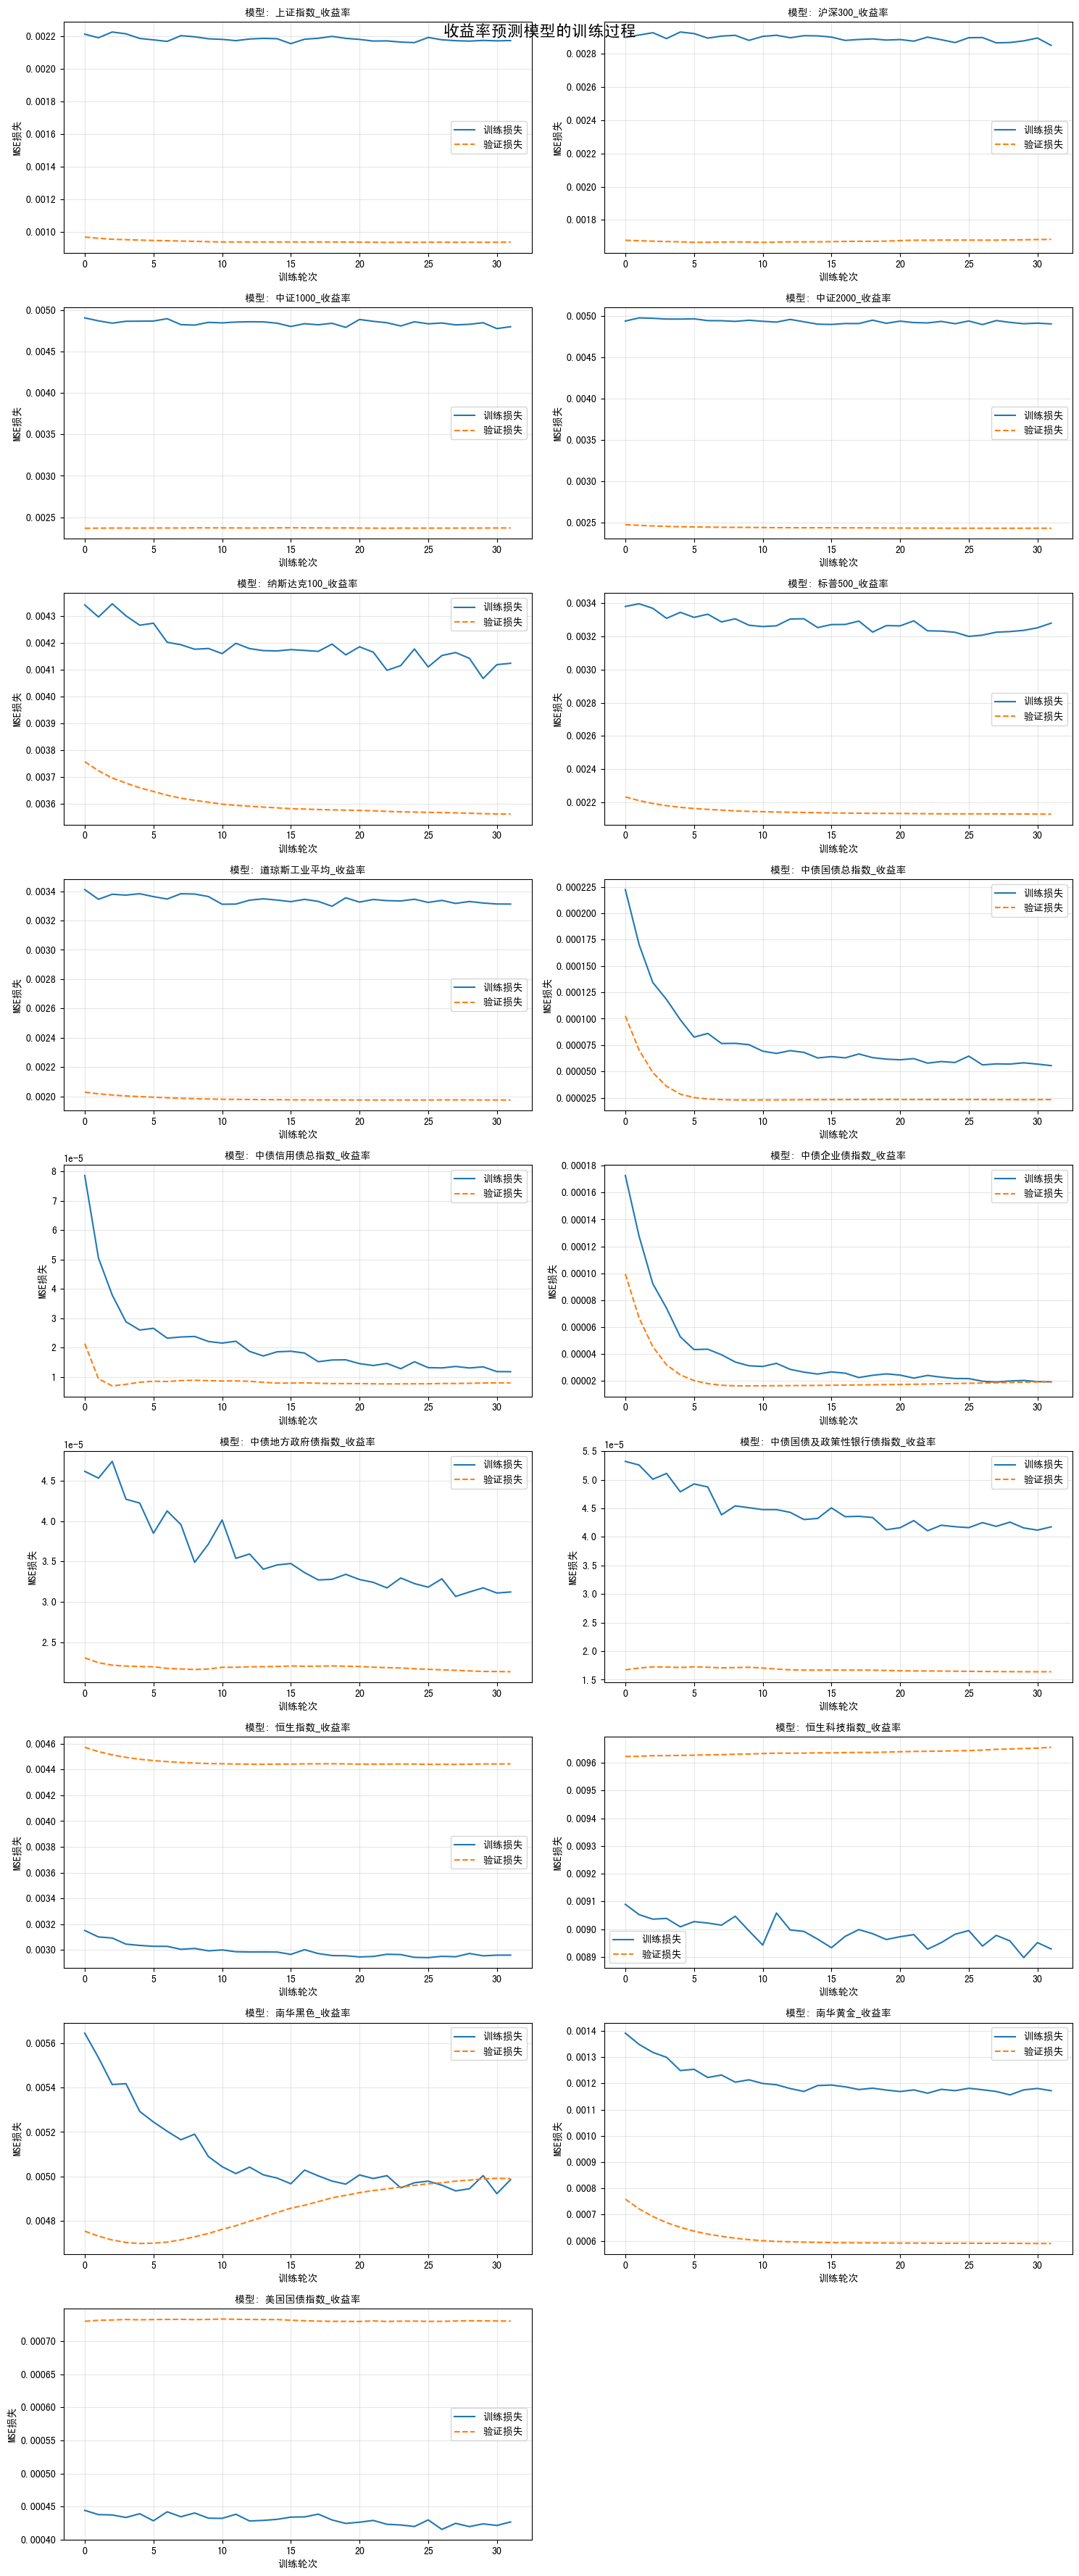

In [32]:
# 可视化收益率模型的训练和验证损失
n_models = len(training_history_return)
n_rows = (n_models + 1) // 2  # 计算需要的行数
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(15, 4*n_rows))
fig.suptitle('收益率预测模型的训练过程', fontsize=16, y=0.98)
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# 遍历所有模型的训练过程
for idx, (column, history) in enumerate(training_history_return.items()):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col] if n_rows > 1 else axes[col]
    
    # 绘制训练/验证损失曲线
    ax.plot(history.history['loss'], label='训练损失')
    ax.plot(history.history['val_loss'], label='验证损失', linestyle='--')
    ax.set_title(f'模型: {column}', fontsize=10)
    ax.set_xlabel('训练轮次')
    ax.set_ylabel('MSE损失')
    ax.legend()
    ax.grid(True, alpha=0.3)

# 如果模型数量为奇数，删除最后一个空白子图
if n_models % 2 == 1:
    fig.delaxes(axes[n_rows-1, 1] if n_rows > 1 else axes[1])

plt.tight_layout()
plt.show()

In [33]:
# 评估收益率模型的预测结果
evaluation_metrics_returns = {}
for i, column in enumerate(r_and_v.columns[:17]):
    y_test_column = y_test_return[:, i].reshape(-1, 1)
    predictions = training_history_return[column].model.predict(X_test)
    mae = mean_absolute_error(y_test_column, predictions)
    mse = mean_squared_error(y_test_column, predictions)
    r2 = r2_score(y_test_column, predictions)
    evaluation_metrics_returns[column] = {'平均绝对误差 (MAE)': mae, '均方误差 (MSE)': mse, '决定系数 (R²)': r2}
    
evaluation_metrics_returns_df = pd.DataFrame(evaluation_metrics_returns).T
evaluation_metrics_returns_df

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


,平均绝对误差 (MAE),均方误差 (MSE),决定系数 (R²)
上证指数_收益率,0.036744,0.002793,0.003620
沪深300_收益率,0.038991,0.003404,-0.000133
中证1000_收益率,0.069827,0.008085,0.007266
中证2000_收益率,0.087081,0.012387,-0.004342
纳斯达克100_收益率,0.035860,0.002366,-0.004875
标普500_收益率,0.028665,0.001352,-0.017939
道琼斯工业平均_收益率,0.025967,0.001109,0.009903
中债国债总指数_收益率,0.006130,0.000065,-0.052543
中债信用债总指数_收益率,0.002163,0.000007,-0.009900
中债企业债指数_收益率,0.002661,0.000012,-0.099766


In [34]:
mae_hist_vs_true = {}
mae_model_vs_true = {}
mae_hist_avg_vs_true = {}
for i, column in enumerate(r_and_v.columns[:17]):
    # 历史法预测值与真实值
    mae_hist = mean_absolute_error(y_test_return[:, i], y_return_hist[split_index:, i])
    mae_hist_1 = mean_absolute_error(y_test_return[:, i], y_return_hist_1[split_index:, i])
    # 模型预测值与真实值
    model_pred = training_history_return[column].model.predict(X_test).flatten()
    mae_model = mean_absolute_error(y_test_return[:, i], model_pred)
    mae_hist_vs_true[column] = mae_hist
    mae_hist_avg_vs_true[column] = mae_hist_1
    mae_model_vs_true[column] = mae_model

mae_compare_df = pd.DataFrame({
    '历史法MAE': mae_hist_vs_true,
    '历史均值MAE': mae_hist_avg_vs_true,
    '模型预测MAE': mae_model_vs_true
})
mae_compare_df

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,历史法MAE,历史均值MAE,模型预测MAE
上证指数_收益率,0.054210,0.037061,0.036744
沪深300_收益率,0.058434,0.038894,0.038991
中证1000_收益率,0.094857,0.069644,0.069827
中证2000_收益率,0.121507,0.086571,0.087081
纳斯达克100_收益率,0.047394,0.038103,0.035860
标普500_收益率,0.034978,0.030300,0.028665
道琼斯工业平均_收益率,0.038610,0.027256,0.025967
中债国债总指数_收益率,0.008385,0.007933,0.006130
中债信用债总指数_收益率,0.002844,0.003379,0.002163
中债企业债指数_收益率,0.003148,0.004102,0.002661


### 4.3 波动率预测模型

#### 4.3.1 模型架构
与收益率模型相同，但学习率调整为0.0001

#### 4.3.2 模型训练与评估
- 训练过程可视化
- 模型性能评估
- 与历史波动率法对比

In [35]:
# 建立并训练波动率的 LSTM 模型
training_history_volatility = {}
for i, column in enumerate(r_and_v.columns[17:]):
    print(f'训练波动率的 LSTM 模型: {column}')
    y_train_column = y_train_volatility[:, i].reshape(-1, 1)
    inputs = Input(shape=(lookback_window, X_train.shape[2]))
    x = LSTM(64, activation='relu', return_sequences=True, dropout=0.1, recurrent_dropout=0.3)(inputs)
    x = Dropout(0.4)(x)
    x = LSTM(32, activation='relu', dropout=0.1, recurrent_dropout=0.3)(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)
    lstm_model = Model(inputs=inputs, outputs=outputs)
    adam_optimizer = Adam(learning_rate=0.00001)
    lstm_model.compile(optimizer=adam_optimizer, loss='mse')
    history = lstm_model.fit(
        X_train, y_train_column,
        epochs=25, batch_size=32,
        validation_split=0.3,
        verbose=1
    )
    training_history_volatility[column] = history

训练波动率的 LSTM 模型: 上证指数_收益率_波动率
Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.4168e-04 - val_loss: 2.8799e-05
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.9934e-05 - val_loss: 1.2249e-05
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.0177e-05 - val_loss: 4.8658e-06
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.2415e-05 - val_loss: 2.7372e-06
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.1688e-05 - val_loss: 3.2660e-06
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.4047e-05 - val_loss: 4.8964e-06
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.2007e-05 - val_loss: 6.4719e-06
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.9745e-05 - val_loss: 7.8683e-06
Epoch 9/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.7874e-05 - val_loss: 8.4392e-06
Epoch 10/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.9111e-05 - val_loss: 8.8602e-06
Epoch 11/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1

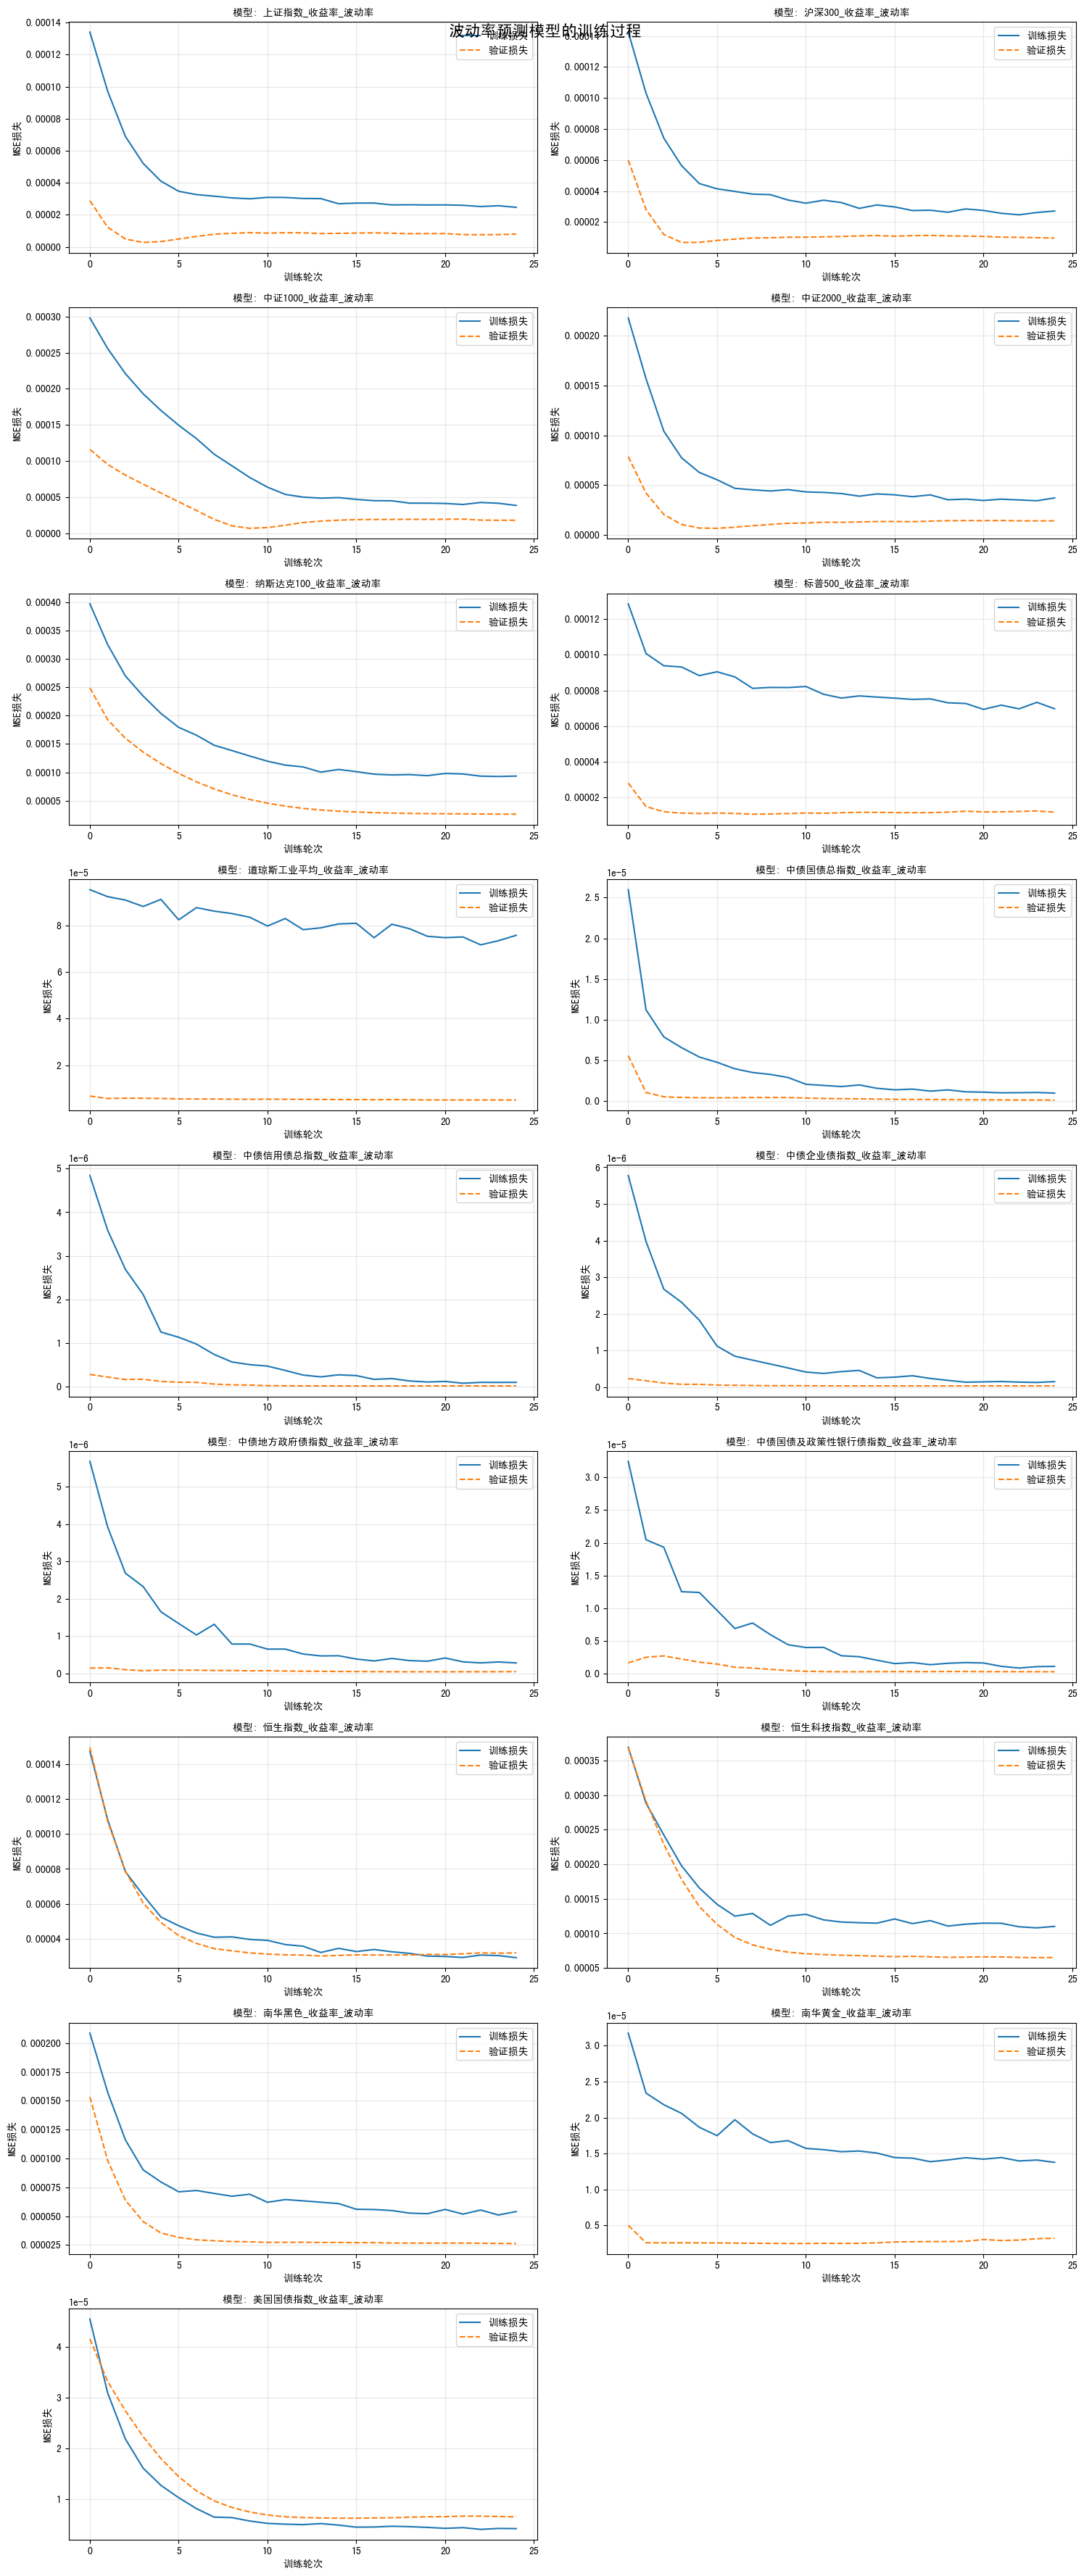

In [36]:
# 可视化波动率模型的训练和验证损失
n_models = len(training_history_volatility)
n_rows = (n_models + 1) // 2  # 计算需要的行数
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(15, 4*n_rows))
fig.suptitle('波动率预测模型的训练过程', fontsize=16, y=0.98)
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# 遍历所有模型的训练过程
for idx, (column, history) in enumerate(training_history_volatility.items()):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col] if n_rows > 1 else axes[col]
    
    # 绘制训练/验证损失曲线
    ax.plot(history.history['loss'], label='训练损失')
    ax.plot(history.history['val_loss'], label='验证损失', linestyle='--')
    ax.set_title(f'模型: {column}', fontsize=10)
    ax.set_xlabel('训练轮次')
    ax.set_ylabel('MSE损失')
    ax.legend()
    ax.grid(True, alpha=0.3)

# 如果模型数量为奇数，删除最后一个空白子图
if n_models % 2 == 1:
    fig.delaxes(axes[n_rows-1, 1] if n_rows > 1 else axes[1])

plt.tight_layout()
plt.show()

In [37]:
# 评估波动率模型的预测结果
evaluation_metrics_volatility = {}
for i, column in enumerate(r_and_v.columns[17:]):
    y_test_column = y_test_volatility[:, i].reshape(-1, 1)
    predictions = training_history_volatility[column].model.predict(X_test)
    mae = mean_absolute_error(y_test_column, predictions)
    mse = mean_squared_error(y_test_column, predictions)
    r2 = r2_score(y_test_column, predictions)
    evaluation_metrics_volatility[column] = {'平均绝对误差 (MAE)': mae, '均方误差 (MSE)': mse, '决定系数 (R²)': r2}

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [38]:
evaluation_metrics_volatility_df = pd.DataFrame(evaluation_metrics_volatility).T
evaluation_metrics_volatility_df

,平均绝对误差 (MAE),均方误差 (MSE),决定系数 (R²)
上证指数_收益率_波动率,0.003965,3.133655e-05,0.004695
沪深300_收益率_波动率,0.004275,3.817821e-05,-0.041415
中证1000_收益率_波动率,0.005959,8.041492e-05,-0.388400
中证2000_收益率_波动率,0.008062,1.261238e-04,-0.772553
纳斯达克100_收益率_波动率,0.004171,4.175677e-05,0.012461
标普500_收益率_波动率,0.003646,3.183103e-05,0.037181
道琼斯工业平均_收益率_波动率,0.003505,2.293686e-05,0.000893
中债国债总指数_收益率_波动率,0.000707,8.026005e-07,-1.390355
中债信用债总指数_收益率_波动率,0.000130,3.130085e-08,-0.083847
中债企业债指数_收益率_波动率,0.000126,3.691622e-08,-0.016146


In [39]:
mae_vol_hist_vs_true = {}
mae_vol_model_vs_true = {}
for i, column in enumerate(r_and_v.columns[17:]):
    # 历史法预测值与真实值
    mae_hist = mean_absolute_error(y_test_volatility[:, i], y_volatility_hist[split_index:, i])
    # 模型预测值与真实值
    model_pred = training_history_volatility[column].model.predict(X_test).flatten()
    mae_model = mean_absolute_error(y_test_volatility[:, i], model_pred)
    mae_vol_hist_vs_true[column] = mae_hist
    mae_vol_model_vs_true[column] = mae_model

mae_vol_compare_df = pd.DataFrame({
    '历史法MAE': mae_vol_hist_vs_true,
    '模型预测MAE': mae_vol_model_vs_true
})
mae_vol_compare_df

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,历史法MAE,模型预测MAE
上证指数_收益率_波动率,0.004755,0.003965
沪深300_收益率_波动率,0.004984,0.004275
中证1000_收益率_波动率,0.007994,0.005959
中证2000_收益率_波动率,0.009636,0.008062
纳斯达克100_收益率_波动率,0.006381,0.004171
标普500_收益率_波动率,0.004710,0.003646
道琼斯工业平均_收益率_波动率,0.004111,0.003505
中债国债总指数_收益率_波动率,0.000654,0.000707
中债信用债总指数_收益率_波动率,0.000151,0.000130
中债企业债指数_收益率_波动率,0.000169,0.000126
